Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.198e+02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 8.509e-14 (tol = 1.000e-10) r (rel) = 3.872e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.374e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.029e-14 (tol = 1.000e-10) r (rel) = 4.639e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.573e+01 (tol = 1.000e-10) r (rel) = 1.000e+

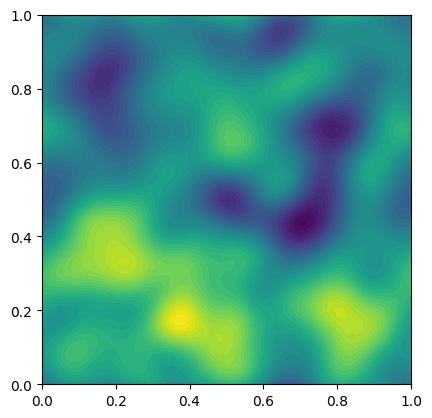

In [1]:
from dolfin import *
import numpy as np
from numpy.random import random


# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and \
                (not ((near(x[0], 0) and near(x[1], 1)) or \
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)





    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.

#Initial condtions (Random)
class IC(UserExpression):
    def eval(self,values,x):
        values[0] = 0.1*random() -0.1*random()
        values[1] = 0.1*random() -0.1*random()
    def value_shape(self):
        return(2,)
    


# Class for interfacing with the Newton solver
class TuringInstability(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)



#Parameters
gamma = 0.9
alpha = 6
beta = 4
d = 20
dt = 5.0e-06

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["representation"] = "quadrature"

# Create mesh and finite element
mesh = UnitSquareMesh(60, 60)
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element, constrained_domain=PeriodicBoundary())
plot(mesh)

# Condensed definition and encapsulation of functions
du       =TrialFunction(V)
v_1, v_2 = TestFunctions(V)
u        = Function(V)
u_n      = Function(V)

# Split system functions to access components
dc,dmu=split(du)
u_1, u_2= split(u)
u_n1, u_n2 = split(u_n)

#Initializzatioin
u1init = IC(element = u.ufl_element())
u.interpolate(u1init)
u_n.interpolate(u1init)





# Forcing terms (x[0], x[1] are symbolic spatial variables, not (u,v) field variables)

ff = Expression('x[0] - A*x[1] + G*x[0]*x[1] - pow(x[0],3)', A=Constant(6.0), G=Constant(0.9),degree=1)
gg = Expression('x[0] - B*x[1]', B=Constant(4.0),degree=1)



# Define variational problem
F =  (u_1*v_1/dt)*dx \
    + (u_2*v_2/dt)*dx \
    + inner(grad(u_1), grad(v_1))*dx \
    + d*inner(grad(u_2), grad(v_2))*dx \
    -(dot(u_n1,v_1)/dt + dot(u_n2,v_2)/dt)*dx \
    -(dot(ff,v_1) + dot(gg,v_2))*dx 



#Time parameters:
t = 0.0
T=300*dt
#vtk file
vtkfile_u_1 = File("reaction_system/u_1.pvd","compressed")
vtkfile_u_2 = File("reaction_system/u_2.pvd","compressed")

#Jacobian, gateau derivative direction (du)
J=derivative(F,u,du)


while (t<T):
# Update current time
    t += dt
    #u_n.assign(u)
    u_n.assign(u)
    solve(F==0, u,J=J)
    
# Save solution to file (VTK)
    _u_1, _u_2 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    
    plot(u_1)


